## Evaluating the Usage of a Bayesian Logistic Regression Framework for Predicting Stroke

### H. Ko, G. McCauley, E. Tria

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix
import pymc as pm
import arviz as az
import seaborn as sns
import matplotlib.pyplot as plt
import os
import sklearn.metrics as metrics
import warnings
warnings.filterwarnings("ignore")

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
# #!ls '/content/drive/My Drive/Bayes Trace'
# os.chdir('/content/drive/My Drive/Bayes Trace')

In [4]:
# load and clean the data

stroke = pd.read_csv('stroke.csv')

# drop id column and rows with NaNs (bmi has 201 NaNs)
stroke.drop('id', axis=1, inplace=True)
stroke.dropna(inplace=True)
stroke = stroke[stroke['gender'] != 'Other'] # remove 1 instance of 'Other'

# convert two-level categorical predictors into binary variables
stroke['gender'] = (stroke['gender'] == 'Male').astype(int) # Male = 1, Female = 0
stroke['ever_married'] = (stroke['ever_married'] == 'Yes').astype(int) # Married = 1, Single = 0
stroke['Residence_type'] = (stroke['Residence_type'] == 'Urban').astype(int) # Urban = 1, Rural = 0

# drop multilevel categorical predictors
strokes = stroke.drop(['work_type', 'smoking_status'], axis = 1)

# cleaned data (note that the numeric predictors have not been normalized since there is evidence that this is superfluous for logistic regression)
strokes

,gender,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,stroke
0,1,67.0,0,1,1,1,228.69,36.6,1
2,1,80.0,0,1,1,0,105.92,32.5,1
3,0,49.0,0,0,1,1,171.23,34.4,1
4,0,79.0,1,0,1,0,174.12,24.0,1
5,1,81.0,0,0,1,1,186.21,29.0,1
...,...,...,...,...,...,...,...,...,...
5104,0,13.0,0,0,0,0,103.08,18.6,0
5106,0,81.0,0,0,1,1,125.20,40.0,0
5107,0,35.0,0,0,1,0,82.99,30.6,0
5108,1,51.0,0,0,1,0,166.29,25.6,0


In [5]:
# split the data into training and test sets

train, test = train_test_split(strokes, test_size=0.2, random_state=6040)
X_train = train.loc[:, train.columns != 'stroke']
y_train = train.loc[:, 'stroke']
X_test = test.loc[:, test.columns != 'stroke']
y_test = test.loc[:, 'stroke']

In [6]:
discrete_columns = ['gender', 'hypertension', 'heart_disease', 'ever_married', 'Residence_type']
continuous_columns = ['age', 'avg_glucose_level', 'bmi']

In [7]:
X_train_tf = X_train.copy()[discrete_columns]
X_train_tf['gender'] = X_train_tf['gender'].replace(0,"Female")
X_train_tf['gender'] = X_train_tf['gender'].replace(1,"Male")
X_train_tf = X_train_tf.replace(0,"No")
X_train_tf = X_train_tf.replace(1,"Yes")
y_train_tf = y_train.copy()
y_train_tf = y_train_tf.replace(0, "No")
y_train_tf = y_train_tf.replace(1, "Yes")
y_train_tf.value_counts()

No     3752
Yes     174
Name: stroke, dtype: int64

Text(0.5, 1.0, 'Class Imbalance of Response Variable')

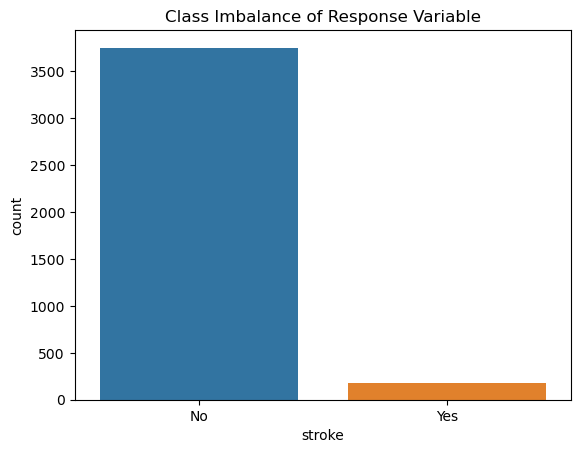

In [8]:
sns.countplot(y_train_tf)
plt.title("Class Imbalance of Response Variable")

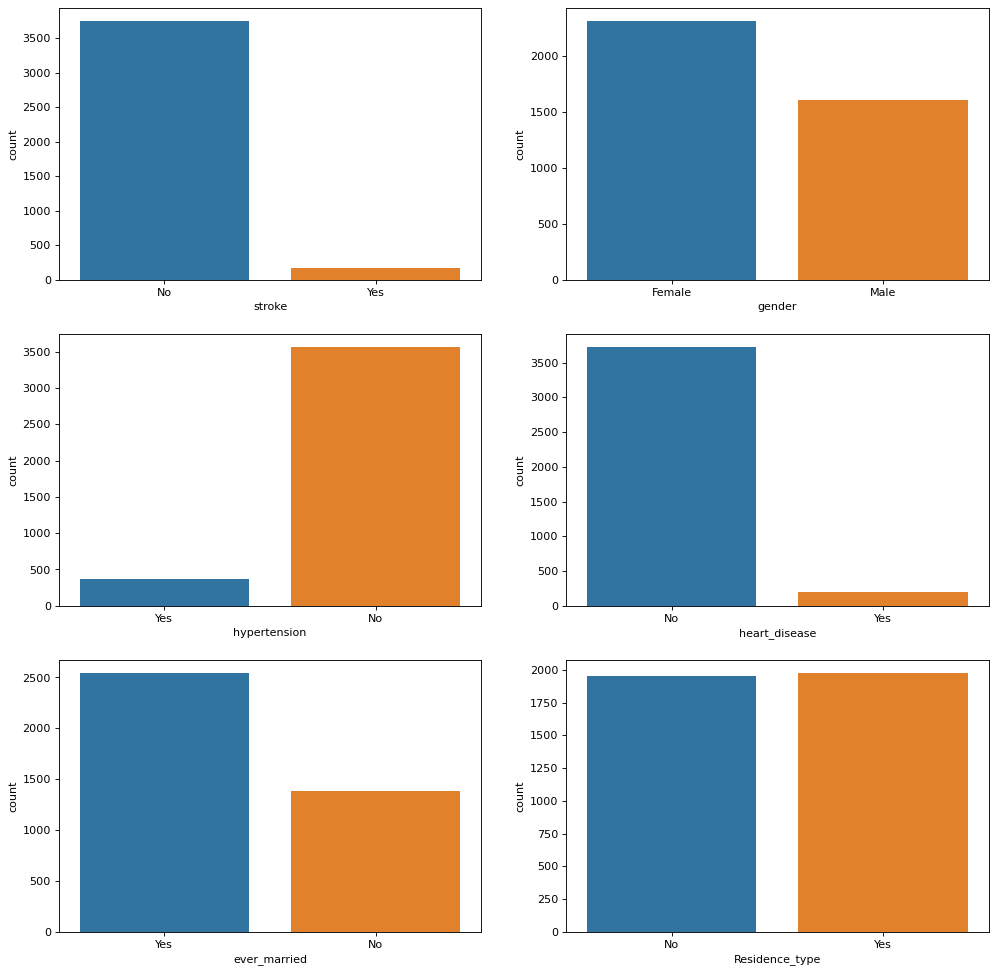

In [9]:
fig, axs = plt.subplots(nrows = 3, ncols = 2, figsize=(15,15), dpi = 80)
count = 0
for i in range (0,3):
    for j in range(0,2):
        if i == 0 and j == 0:
            # first plot uses the count of response variable
            sns.countplot(y_train_tf, ax = axs[i,j])
            
        else:
            col = discrete_columns[count]
            sns.countplot(X_train_tf[col], ax = axs[i,j])
            count += 1

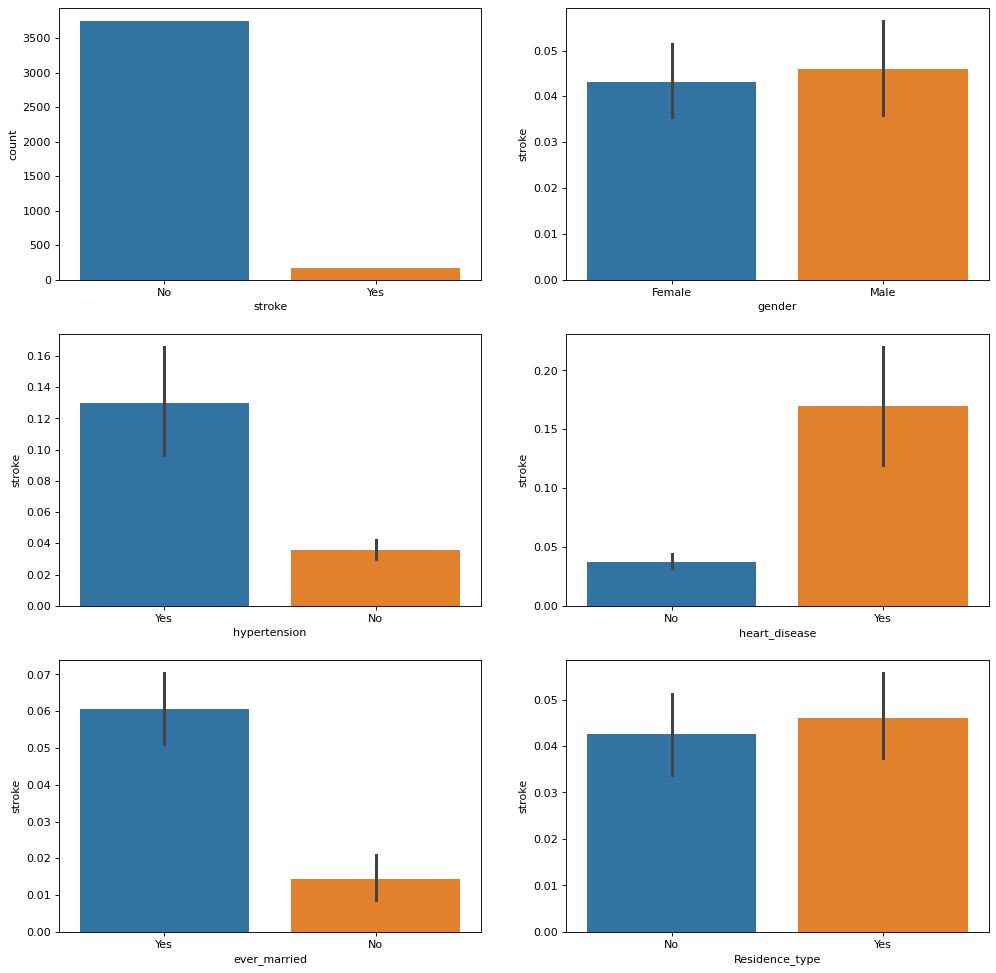

In [10]:
fig, axs = plt.subplots(nrows = 3, ncols = 2, figsize=(15,15), dpi = 80)
count = 0
for i in range (0,3):
    for j in range(0,2):
        if i == 0 and j == 0:
            # first plot uses the count of response variable
            sns.countplot(y_train_tf, ax = axs[i,j])
        else:
            col = discrete_columns[count]
            sns.barplot(X_train_tf[col], y_train, ax = axs[i,j])
            count += 1

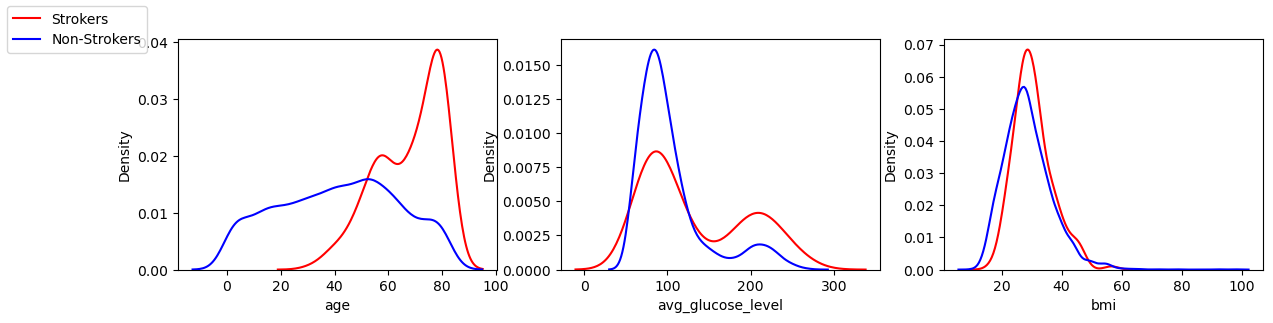

In [11]:
fig, axs = plt.subplots(nrows = 1, ncols = 3, figsize=(14,3))
count = 0
for i in range (0,3):
    col = continuous_columns[i]
    sns.kdeplot(train[train['stroke'] == 1][col], ax = axs[i], color = 'red')
    sns.kdeplot(train[train['stroke'] == 0][col], ax = axs[i], color = 'blue')
fig.legend(loc='upper left', labels= ['Strokers', 'Non-Strokers'])

In [12]:
# create a dictionary to access the feature names

beta_dict = dict()
count = 0
for col in X_train.columns:
    beta_dict[str(count)] = col
    count += 1
    
beta_dict['1']

'age'

In [13]:
# function to get the precision, accuracy, and recall given a confusion matrix

def get_rates(A):
    TN = A[0,0]
    FN = A[1,0]
    FP = A[0,1]
    TP = A[1,1]

    rates = dict()
    rates['Precision'] = round(TP / (TP + FP), 3)
    rates['Accuracy'] = round((TP + TN) / (TP + TN + FP + FN),3)
    rates['Recall'] = round(TP / (TP + FN), 3) 
    return rates

In [14]:
def get_cost(A, fp_cost=1, fn_cost=50):
    FN = A[0,1]
    FP = A[1,0]
    return fp_cost * FP + fn_cost * FN

## Model 1: Full Sampling Model (8 predictors)

- Result: {'Precision': 0.997, 'Accuracy': 0.713, 'Recall': 0.704}

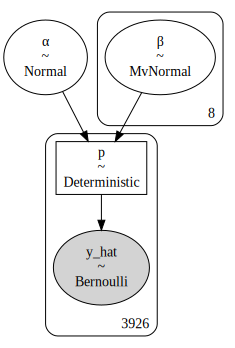

In [15]:
# build the full Bayesian logistic regression model

with pm.Model() as logistic_regression:
    
    k = X_train.shape[1]
    
    # Gaussian priors for random intercepts and slopes
    α = pm.Normal('α', mu=0., sigma=100)
    β = pm.MvNormal('β', mu=np.zeros(k), cov=100*np.eye(k), shape=k)
    
    # Calculate the logit 
    μ = α + pm.math.dot(np.array(X_train),β)
    p = pm.Deterministic('p',  pm.invlogit(μ))
    
    # Pass the logits to a Bernoulli outcome, with the observed data
    y_hat = pm.Bernoulli('y_hat', p=p, observed=y_train)
    
# the graphical model
fig1 = pm.model_to_graphviz(logistic_regression)
fig1

In [16]:
fig1.render(filename='graph1',format='png');

In [17]:
# run HMC sampling for the full model

# with logistic_regression:
#     full_trace = pm.sample(10000, cores = 4, random_seed = 6040)

In [18]:
# saving and reading trace results

full_trace_fpath = 'full_trace.nc'
# full_trace.to_netcdf(full_trace_fpath)

# uncomment to read trace from file:
full_trace = az.from_netcdf(full_trace_fpath)

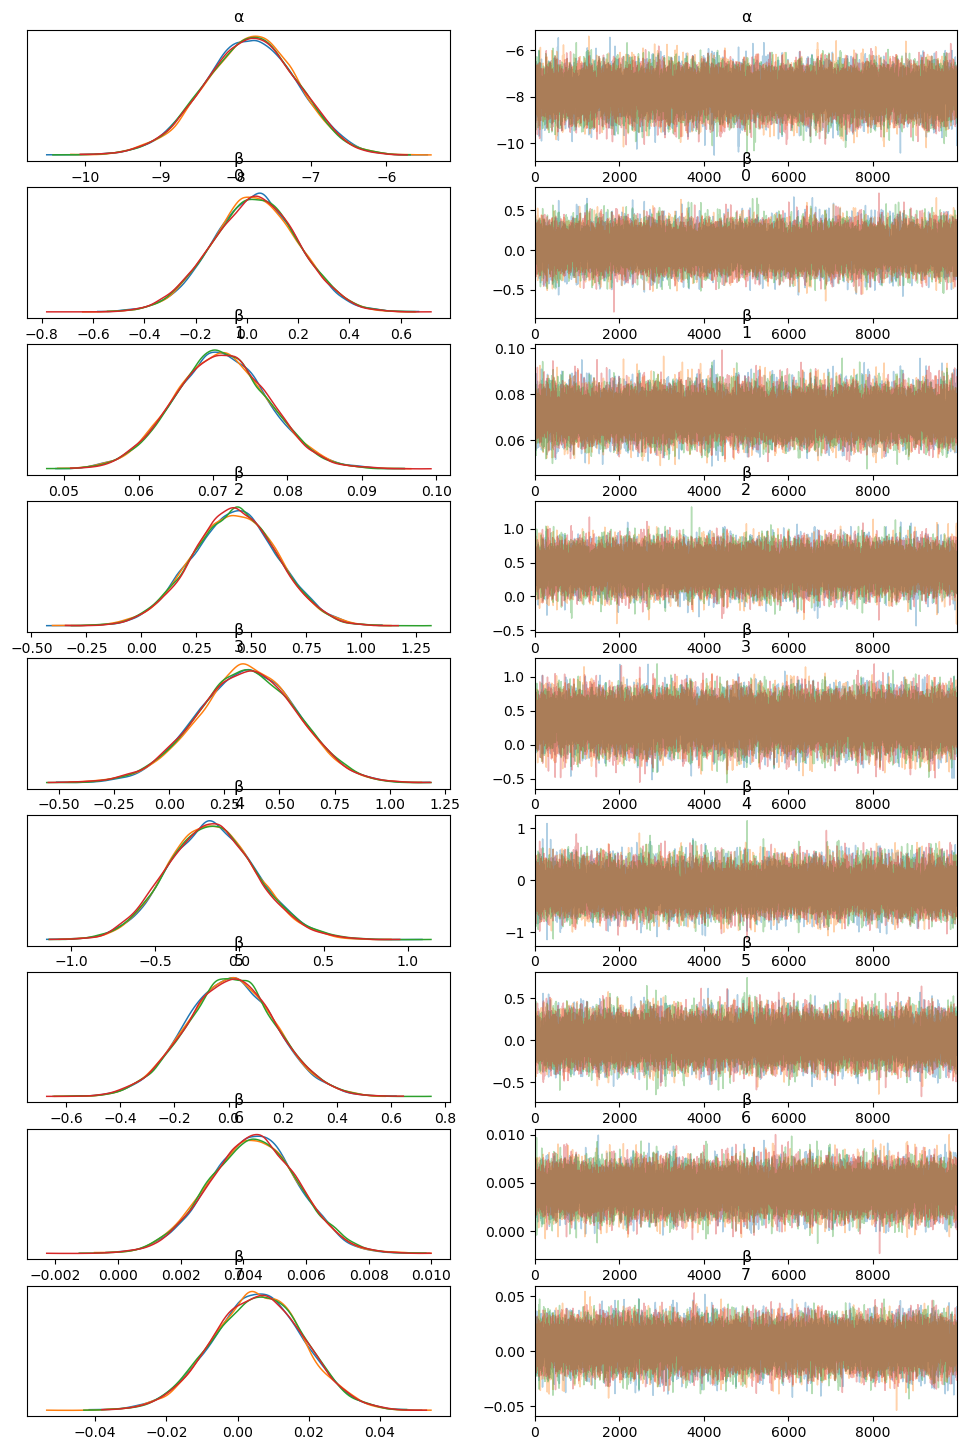

In [19]:
# trace plots

fig2 = az.plot_trace(full_trace, compact = False, var_names = ['α','β']);


array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

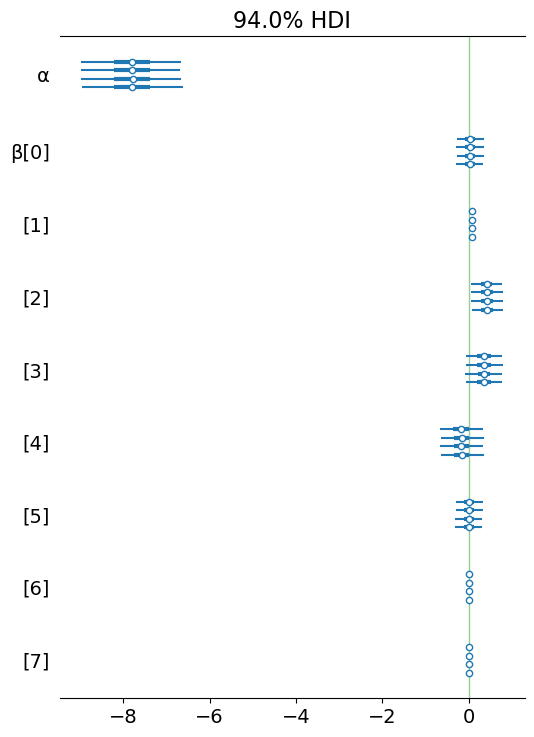

In [20]:
# forest plots

az.plot_forest(full_trace, var_names = ['α','β'], rope=(0,0))

In [21]:
# summary table

az.summary(full_trace, var_names = ['α','β'], round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
α,-7.81,0.62,-8.96,-6.64,0.0,0.0,28421.10,28019.40,1.0
β[0],0.03,0.17,-0.28,0.35,0.0,0.0,48045.93,28547.77,1.0
β[1],0.07,0.01,0.06,0.08,0.0,0.0,34592.09,28630.74,1.0
β[2],0.42,0.20,0.06,0.79,0.0,0.0,55406.40,27643.87,1.0
β[3],0.35,0.23,-0.07,0.78,0.0,0.0,48196.08,29012.39,1.0
β[4],-0.16,0.27,-0.66,0.34,0.0,0.0,45985.07,27618.89,1.0
β[5],0.01,0.17,-0.31,0.32,0.0,0.0,49788.86,27040.43,1.0
β[6],0.00,0.00,0.00,0.01,0.0,0.0,53658.69,28785.46,1.0
β[7],0.01,0.01,-0.02,0.03,0.0,0.0,37327.25,29522.74,1.0


In [22]:
print(beta_dict['1'])
print(beta_dict['2'])

age
hypertension


In [23]:
def inv_logit(p):
    return np.exp(p) / (1 + np.exp(p))

def calculate_tstar(p, y_hat, y_test):
    t = np.linspace(0,1,101)
    accuracies = np.full(len(t), None)
    TPs = np.full(len(t), None)
    FPs = np.full(len(t), None)
    TNs = np.full(len(t), None)
    FNs = np.full(len(t), None)
    for i in range(len(t)):
        y_hat = (p>=t[i]).astype(int)
        accuracies[i] = sum(y_hat == y_test)/len(y_test)
        TPs[i] = sum(np.all([y_hat == 1, y_test == 1], axis=0))
        FPs[i] = sum(np.all([y_hat == 1, y_test == 0], axis=0))
        TNs[i] = sum(np.all([y_hat == 0, y_test == 0], axis=0))
        FNs[i] = sum(np.all([y_hat == 0, y_test == 1], axis=0))

    # Using 50 as the cost of misclassification
    t_star = t[np.argmin(FPs + 50*FNs)]
    return t_star


In [24]:
a = full_trace.posterior['α'].mean(axis=1).mean(axis=0).to_numpy()
b = full_trace.posterior['β'].mean(axis=1).mean(axis=0).to_numpy()

m = a + X_test.dot(b)
p = inv_logit(m)

t_star_full = calculate_tstar(p, y_hat, y_test)
print('Optimal Threshold:', t_star_full)
sum((p>=t_star_full).astype(int) == y_test)/len(y_test)

Optimal Threshold: 0.04


0.7128309572301426

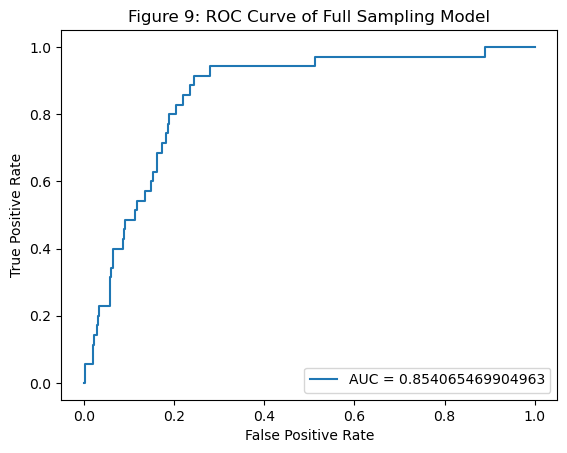

In [25]:
# ROC Curve

fpr, tpr, _ = metrics.roc_curve(y_test,  p)
auc = metrics.roc_auc_score(y_test, p)

plt.plot(fpr, tpr, label = "AUC = "+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.title("Figure 9: ROC Curve of Full Sampling Model")
plt.savefig("full_roc.png")
plt.show()


In [26]:
# Confusion Matrix

cm = metrics.confusion_matrix(y_test, (p>=t_star_full).astype(int))
print(cm)

get_rates(cm)

[[667 280]
 [  2  33]]


{'Precision': 0.105, 'Accuracy': 0.713, 'Recall': 0.943}

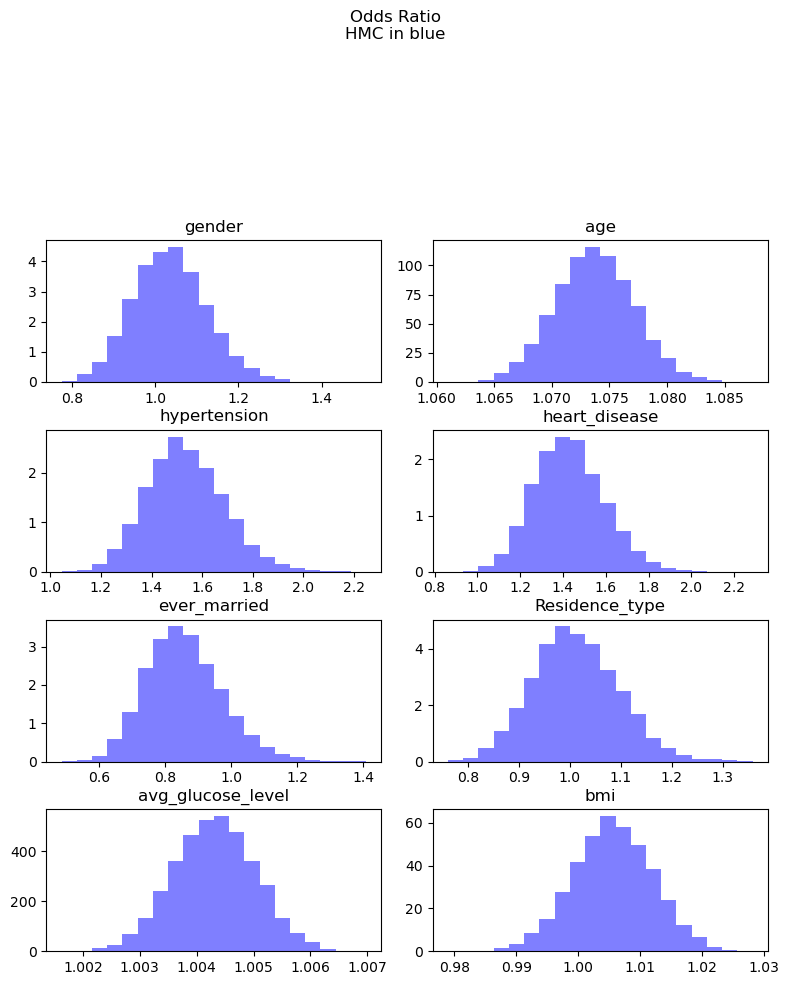

In [27]:
# Odds ratio for all parameters (Full model)
# Odds ratio = pr() / 1 - pr()

full_betas = full_trace.posterior['β']
full_predictor_cols = list(X_train.columns)
k = len(full_predictor_cols)

fig, axes = plt.subplots(nrows = 4, ncols = 2, figsize = (8, 10), dpi = 100, constrained_layout = False)

for ax, estimate_sample, title, xlabel in zip(
    axes.ravel(),
    [full_betas[:,:,i] for i in range(k)],
    full_predictor_cols,
    full_predictor_cols):
    
    OR_sample = np.mean(estimate_sample, axis=0)
    ax.hist(np.exp(OR_sample), bins=20, density=True, color = 'blue', alpha = 0.5)
    ax.set_title(title, fontsize=12)
    
plt.suptitle('Odds Ratio\nHMC in blue')
plt.tight_layout()
plt.subplots_adjust(top = 0.75)
plt.show()

## Model 2: Full ADVI Model (8 predictors)


- Result: {'Precision': 0.997, 'Accuracy': 0.686, 'Recall': 0.677}

In [28]:
# Variational inference with ADVI optimization

advi_fit = pm.fit(60000, method = 'advi', model = logistic_regression, random_seed=6040)

Finished [100%]: Average Loss = 666.31


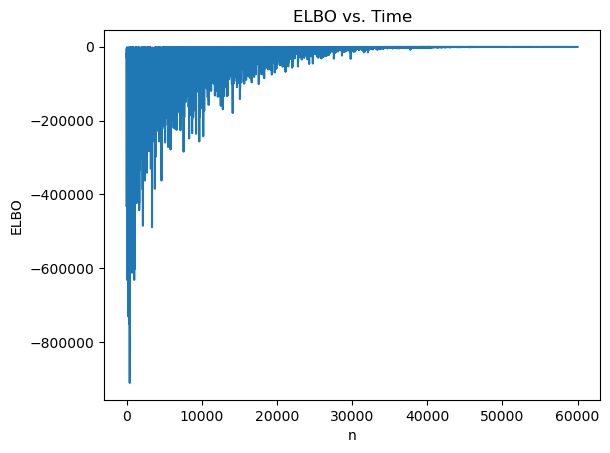

In [29]:
# plot the ELBO over time

advi_elbo = pd.DataFrame(
    {'ELBO': -advi_fit.hist,
     'n': np.arange(advi_fit.hist.shape[0])})

_ = sns.lineplot(y='ELBO', x='n', data=advi_elbo)
_.set_title('ELBO vs. Time');

In [30]:
# sample from the variational posterior distribution

full_advi_trace = advi_fit.sample(10000, random_seed = 6040)

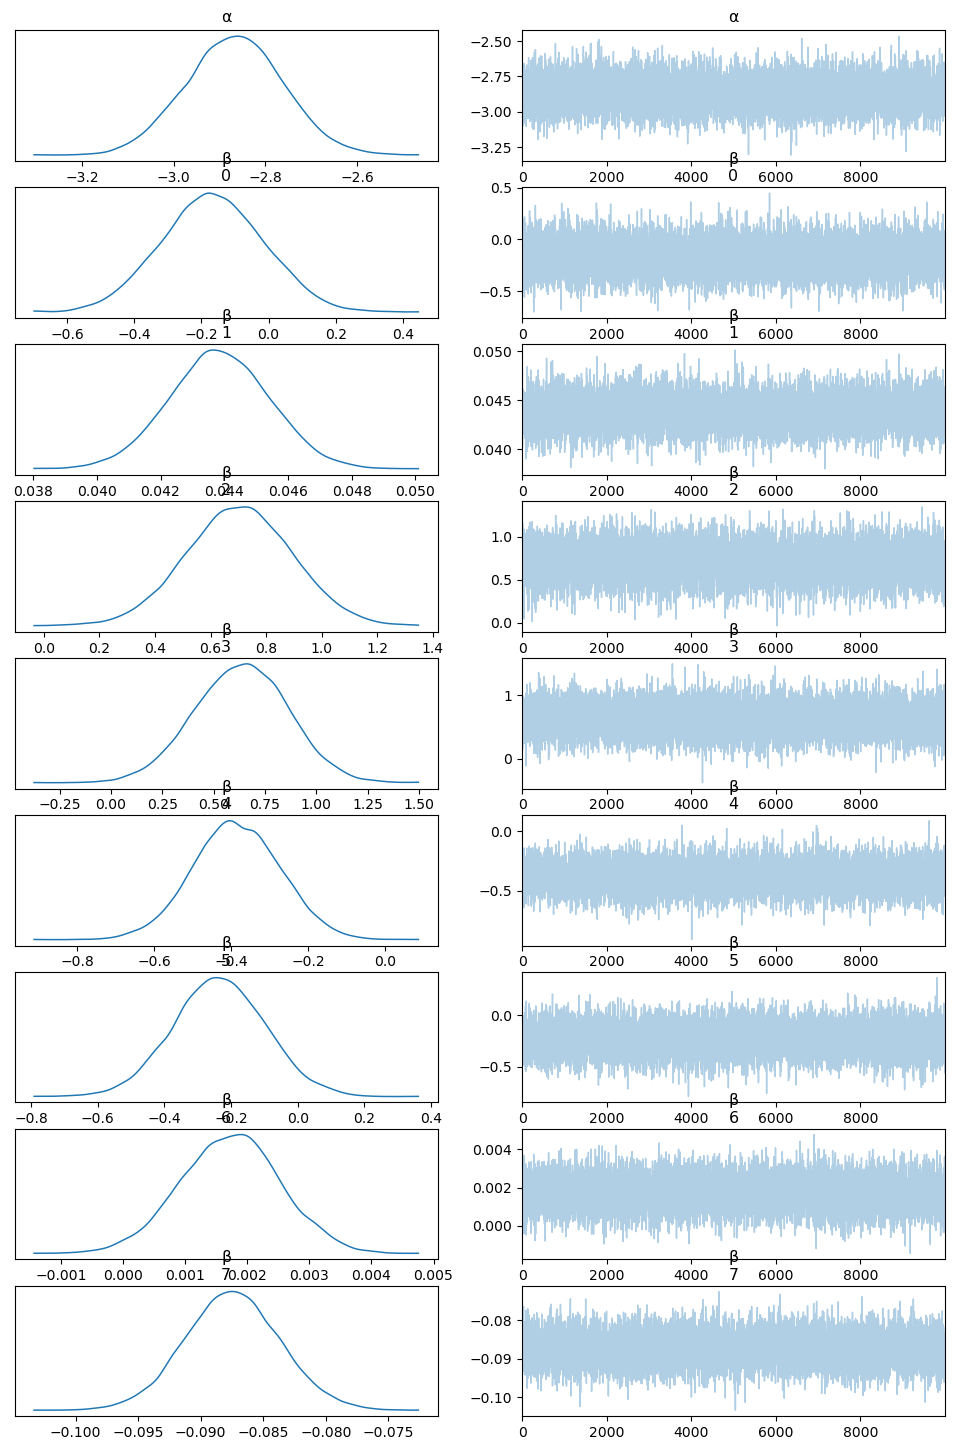

In [31]:
# trace plots

az.plot_trace(full_advi_trace, compact = False, var_names = ['α','β']);

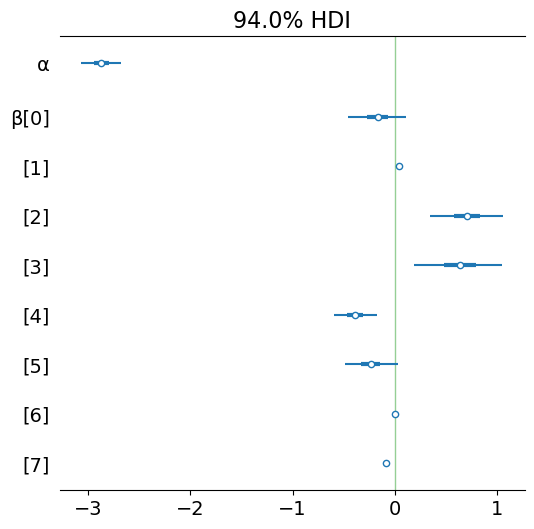

In [32]:
# forest plots

az.plot_forest(full_advi_trace, var_names = ['α','β'], rope=(0,0));

### Poor convergence for two predictors may be attributed to huge class imbalance? (And the fact that there are no observations where 'stroke' is 1 and either of these variables is 1.)

In [33]:
# summary table

az.summary(full_advi_trace, var_names = ['α','β'], round_to=2)

arviz - WARNING - Shape validation failed: input_shape: (1, 10000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
α,-2.87,0.11,-3.07,-2.67,0.0,0.0,9837.03,9636.59,NaN
β[0],-0.17,0.15,-0.45,0.11,0.0,0.0,9620.83,9342.89,NaN
β[1],0.04,0.00,0.04,0.05,0.0,0.0,8548.56,9378.23,NaN
β[2],0.70,0.19,0.34,1.06,0.0,0.0,10149.82,9883.38,NaN
β[3],0.63,0.23,0.19,1.04,0.0,0.0,9735.82,9581.93,NaN
β[4],-0.39,0.11,-0.60,-0.17,0.0,0.0,9766.66,9370.84,NaN
β[5],-0.24,0.14,-0.49,0.03,0.0,0.0,9892.28,9876.61,NaN
β[6],0.00,0.00,0.00,0.00,0.0,0.0,9882.37,9351.07,NaN
β[7],-0.09,0.00,-0.09,-0.08,0.0,0.0,9985.12,9756.59,NaN


The summary table for the ADVI trace indicates that more of the variables are statistically significant than just 'age' and 'hypertension' as the HMC sampling trace suggests.

In [34]:
a = full_advi_trace.posterior['α'].mean(axis=1).mean(axis=0).to_numpy()
b = full_advi_trace.posterior['β'].mean(axis=1).mean(axis=0).to_numpy()

m = a + X_test.dot(b)
p = inv_logit(m)

t_star_full_advi = calculate_tstar(p, y_hat, y_test)
print('Optimal Threshold:', t_star_full_advi)
sum((p>=t_star_full_advi).astype(int) == y_test)/len(y_test)

Optimal Threshold: 0.04


0.7331975560081466

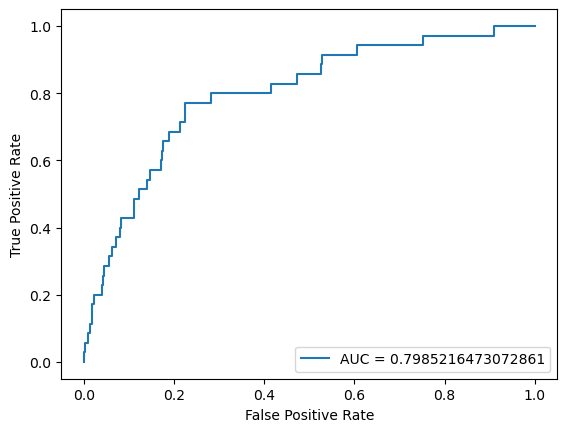

In [35]:
# ROC Curve

fpr, tpr, _ = metrics.roc_curve(y_test,  p)
auc = metrics.roc_auc_score(y_test, p)

plt.plot(fpr, tpr, label = "AUC = "+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

In [36]:
# Confusion Matrix

cm = metrics.confusion_matrix(y_test, (p>=t_star_full_advi).astype(int))
print(cm)

get_rates(cm)

[[693 254]
 [  8  27]]


{'Precision': 0.096, 'Accuracy': 0.733, 'Recall': 0.771}

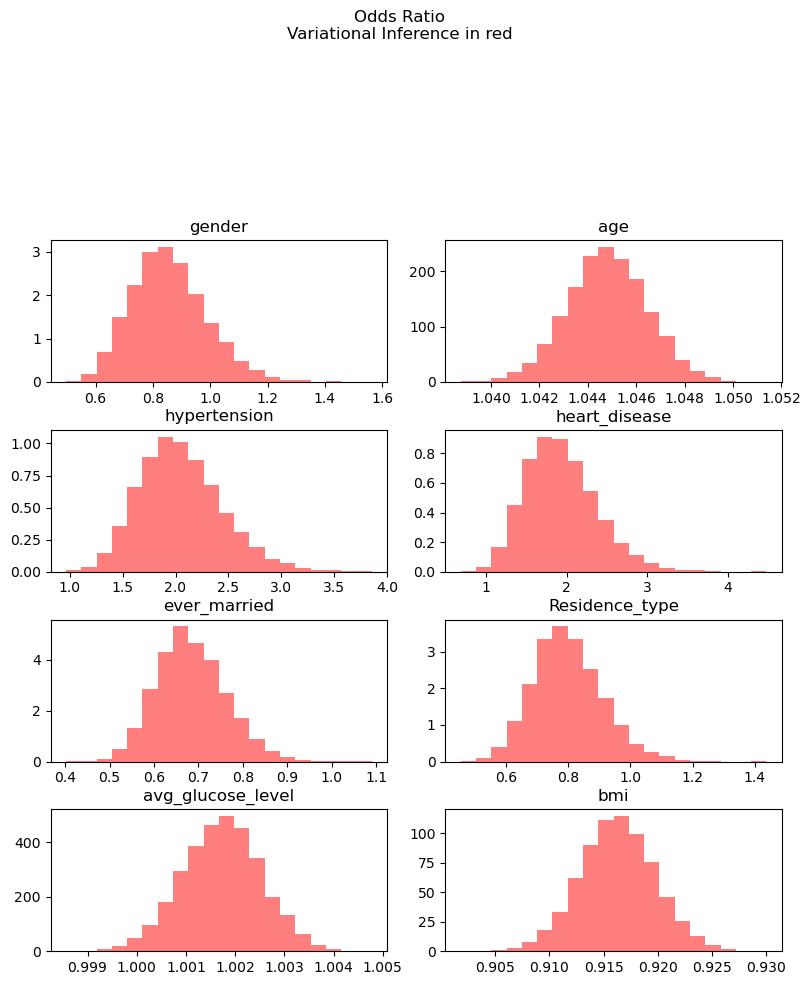

In [37]:
# Odds ratio for all parameters (Full Model ADVI)
# Odds ratio = pr() / 1 - pr()

full_advi_betas = full_advi_trace.posterior['β']
full_predictor_cols = list(X_train.columns)
k = len(full_predictor_cols)

fig, axes = plt.subplots(nrows = 4, ncols = 2, figsize = (8, 10), dpi = 100, constrained_layout = False)

for ax, estimate_advi, title, xlabel in zip(
    axes.ravel(),
    [full_advi_betas[:,:,i] for i in range(k)],
    full_predictor_cols,
    full_predictor_cols):
    
    OR_advi = np.mean(estimate_advi, axis=0)
    ax.hist(np.exp(OR_advi), bins=20, density=True, color = 'red', alpha = 0.5)
    ax.set_title(title, fontsize=12)
    
plt.suptitle('Odds Ratio\nVariational Inference in red')
plt.tight_layout()
plt.subplots_adjust(top = 0.75)
plt.show()

### Need to decide which variables to remove

#### Will try removing the multilevel categorical predictors

## Model 3: Reduced Sampling Model (Age & Hypertension)


- Result: {'Precision': 0.997, 'Accuracy': 0.686, 'Recall': 0.677}

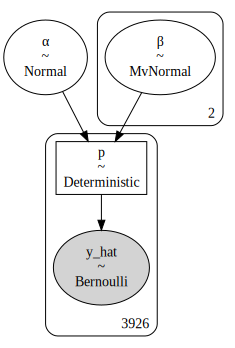

In [38]:
# build the reduced Bayesian logistic regression model

X_train_reduced = X_train[["age", "hypertension"]]

with pm.Model() as logistic_regression_reduced:
    
    k = X_train_reduced.shape[1]
    
    # Gaussian priors for random intercepts and slopes
    α = pm.Normal('α', mu=0., sigma=100)
    β = pm.MvNormal('β', mu=np.zeros(k), cov=100*np.eye(k), shape=k)
    
    # Calculate the logit 
    μ = α + pm.math.dot(np.array(X_train_reduced),β)
    p = pm.Deterministic('p',  pm.invlogit(μ))

    # Pass the logits to a Bernoulli outcome, with the observed data
    y_hat = pm.Bernoulli('y_hat', p=p, observed=y_train)
    
# the graphical model
pm.model_to_graphviz(logistic_regression_reduced)

In [39]:
# HMC sampling for the reduced model

# with logistic_regression_reduced:
#     reduced_trace = pm.sample(10000, cores = 4, random_seed = 6040)

In [40]:
# save and read trace data

reduced_trace_fpath = 'reduced_trace.nc'
# reduced_trace.to_netcdf(reduced_trace_fpath)

# uncomment to read trace from file:
reduced_trace = az.from_netcdf(reduced_trace_fpath)

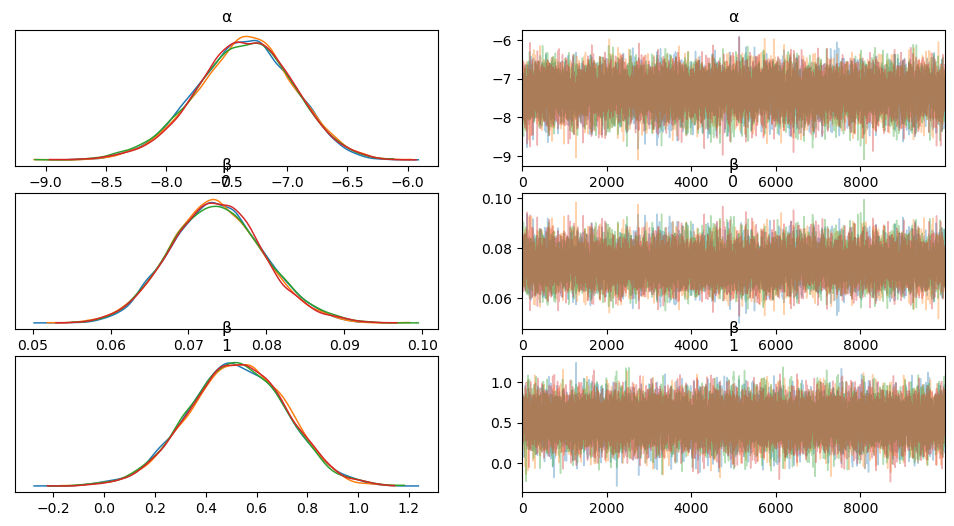

In [41]:
az.plot_trace(reduced_trace, compact = False, var_names = ['α','β']);

array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

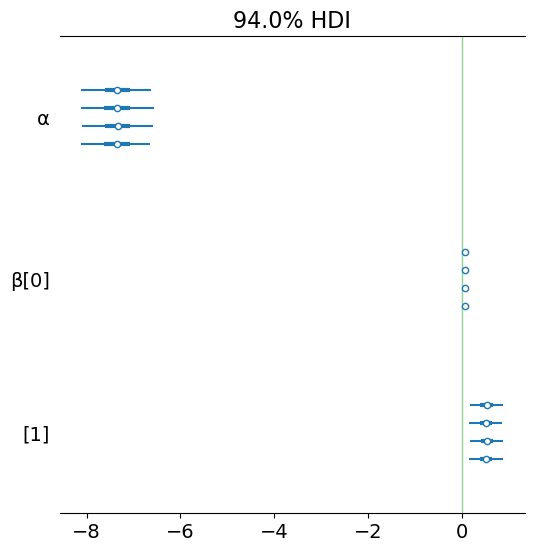

In [42]:
# forest plots

az.plot_forest(reduced_trace, var_names = ['α','β'], rope=(0,0))

In [43]:
# summary table

az.summary(reduced_trace, var_names = ['α','β'], round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
α,-7.36,0.40,-8.10,-6.59,0.0,0.0,12899.91,14098.87,1.0
β[0],0.07,0.01,0.06,0.08,0.0,0.0,12727.58,14233.31,1.0
β[1],0.52,0.19,0.16,0.87,0.0,0.0,19028.53,18754.93,1.0


In [44]:
a = reduced_trace.posterior['α'].mean(axis=1).mean(axis=0).to_numpy()
b = reduced_trace.posterior['β'].mean(axis=1).mean(axis=0).to_numpy()

X_test_reduced = X_test[["age", "hypertension"]]

m = a + X_test_reduced.dot(b)
p = inv_logit(m)

t_star_reduced = calculate_tstar(p, y_hat, y_test)
print('Optimal Threshold:', t_star_reduced)
sum((p>=t_star_reduced).astype(int) == y_test)/len(y_test)

Optimal Threshold: 0.04


0.6863543788187373

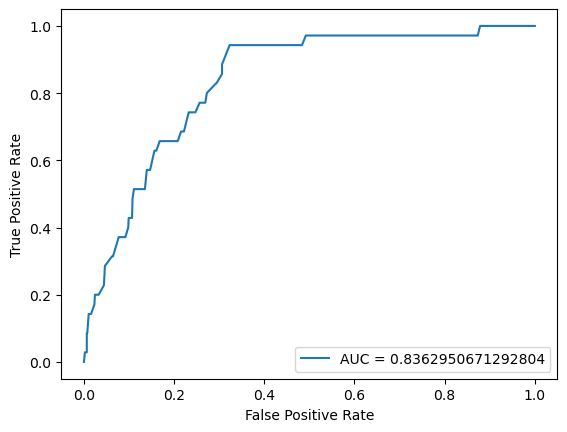

In [45]:
# ROC Curve

fpr, tpr, _ = metrics.roc_curve(y_test,  p)
auc = metrics.roc_auc_score(y_test, p)

plt.plot(fpr, tpr, label = "AUC = "+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

In [46]:
# Confusion Matrix

cm = metrics.confusion_matrix(y_test, (p>=t_star_reduced).astype(int))
print(cm)

get_rates(cm)

[[641 306]
 [  2  33]]


{'Precision': 0.097, 'Accuracy': 0.686, 'Recall': 0.943}

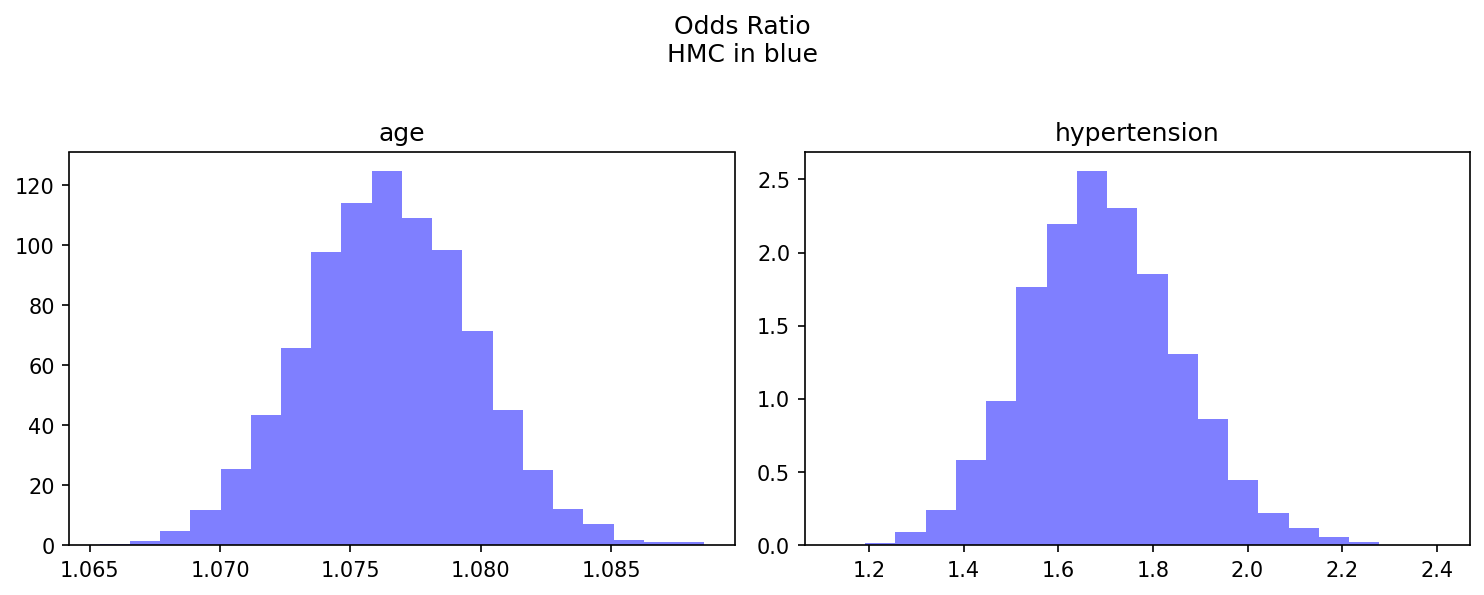

In [47]:
# Odds ratio for reduced parameters (Reduced Model HMC)
# Odds ratio = pr() / 1 - pr()

reduced_betas = reduced_trace.posterior['β']
reduced_predictor_cols = list(X_train_reduced.columns)
k = len(reduced_predictor_cols)

fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (10, 4), dpi = 150, constrained_layout = False)

for ax, estimate_sample, title, xlabel in zip(
    axes.ravel(),
    [reduced_betas[:,:,i] for i in range(k)],
    reduced_predictor_cols,
    reduced_predictor_cols):
    
    OR_sample = np.mean(estimate_sample, axis=0)
    ax.hist(np.exp(OR_sample), bins=20, density=True, color = 'blue', alpha = 0.5)
    ax.set_title(title, fontsize=12)
    
plt.suptitle('Odds Ratio\nHMC in blue')
plt.tight_layout()
plt.subplots_adjust(top = 0.75)
plt.show()

In [48]:
# WAIC

cmp_waic = az.compare({'model_full':full_trace, 'model_reduced':reduced_trace}, ic='waic')
cmp_waic

,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
model_full,0,-573.887623,8.938357,0.000000,0.55937,32.610260,0.000000,False,log
model_reduced,1,-575.013870,2.891536,1.126247,0.44063,32.295276,4.011291,False,log


## Model 4: Bayesian Averaging (Full Sampling & Reduced Sampling)

- Result: {'Precision': 0.997, 'Accuracy': 0.701, 'Recall': 0.692}

In [49]:
# Model function

def lm_full(trace, intercept = 0, hypertension = 0):
    shape = trace['α'].shape
    x = np.linspace(min(X_train['age']), max(X_train['age']), shape[1])
    x = np.array(x)
    z = np.broadcast_to(x, shape)

    return (1 / (
      1
      + np.exp(
          -(
              trace['α']*intercept
              + trace["β"][:,:,1] * z
              + trace["β"][:,:,2] * hypertension
              + trace["β"][:,:,6] * np.mean(X_train['avg_glucose_level'])
              + trace["β"][:,:,7] * np.mean(X_train['bmi'])
          )
      )
    ))

In [50]:
# Model function

def lm_reduced(trace, intercept = 0, hypertension = 0):
    shape = trace['α'].shape
    x = np.linspace(min(X_train['age']), max(X_train['age']), shape[1])
    x = np.array(x)
    z = np.broadcast_to(x, shape)

    return (1 / (
      1
      + np.exp(
          -(
              trace['α']*intercept
              + trace["β"][:,:,0] * z
              + trace["β"][:,:,1] * hypertension
          )
      )
    ))

In [51]:
def plot_posterior_predictive(weights, full_trace, reduced_trace, hypertension_value, plot_title):
    plt.figure(figsize = (10,12))

    shape = full_trace.posterior['α'].shape
    x = np.linspace(min(X_train['age']), max(X_train['age']), shape[1])
    for j in range(3):
        out =[]
        for i in range(4):
            if i == 0:
                if j == 0:
                    out.append(lm_full(full_trace.posterior, intercept=1, hypertension = hypertension_value)[i,:])
                    plt.plot(x,out[i], color = 'red', alpha = 0.5, label = 'Full Model')
                elif j == 1:
                    out.append(lm_reduced(reduced_trace.posterior, intercept=1, hypertension = hypertension_value)[i,:])
                    plt.plot(x,out[i], color = 'blue', alpha = 0.5, label = 'Simple Model')
                else:
                    out.append(weights[0]*lm_full(full_trace.posterior, intercept=1, hypertension = hypertension_value)[i,:]
                               + weights[1]*lm_reduced(reduced_trace.posterior, intercept=1, hypertension = hypertension_value)[i,:])
                    plt.plot(x,out[i], color = 'purple', alpha = 0.5, label = 'BMA Model')
            else:
                if j == 0:
                    out.append(lm_full(full_trace.posterior, intercept=1, hypertension = hypertension_value)[i,:])
                    plt.plot(x,out[i], color = 'red', alpha = 0.5)
                elif j == 1:
                    out.append(lm_reduced(reduced_trace.posterior, intercept=1, hypertension = hypertension_value)[i,:])
                    plt.plot(x,out[i], color = 'blue', alpha = 0.5)
                else:
                    out.append(weights[0]*lm_full(full_trace.posterior, intercept=1, hypertension = hypertension_value)[i,:]
                               + weights[1]*lm_reduced(reduced_trace.posterior, intercept=1, hypertension = hypertension_value)[i,:])
                    plt.plot(x,out[i], color = 'purple', alpha = 0.5)
    plt.title(plot_title)
    plt.xlabel('Age')
    plt.ylabel('Probability of Stroke')
    plt.legend(title = 'Model')
    
def plot_posterior_precitive_using_mean(weights, full_trace, reduced_trace, hypertension_value, plot_title):
    x_new = np.linspace(min(X_train['age']), max(X_train['age']), 100)
    α_l_post = full_trace.posterior['α'].mean(axis=1).mean(axis=0).to_numpy()
    β_l_post = full_trace.posterior['β'].mean(axis=1).mean(axis=0).to_numpy()
    y_l_post = α_l_post + β_l_post[1] * x_new + (β_l_post[2] * hypertension_value) + \
               β_l_post[6]*np.mean(X_train['avg_glucose_level']) + \
               β_l_post[7]*np.mean(X_train['bmi'])
    y_l_post = (1 / (1 + np.exp(-(y_l_post))))
    plt.figure(figsize = (10,10))
    plt.plot(x_new, y_l_post, 'C1', label='Full Model')
    α_p_post = reduced_trace.posterior['α'].mean(axis=1).mean(axis=0).to_numpy()
    β_p_post = reduced_trace.posterior['β'].mean(axis=1).mean(axis=0).to_numpy()
    y_p_post = α_p_post + β_p_post[0] * x_new + (β_l_post[1] * hypertension_value)
    y_p_post = (1 / (1 + np.exp(-(y_p_post))))
    plt.plot(x_new, y_p_post, 'C2', label='Simple Model')
    y_bma_post = (1-w)*y_p_post+w*y_l_post
    
    plt.plot(x_new, y_bma_post, 'C3', label='BMA Model')
    plt.title(plot_title)
    plt.xlabel('Age')
    plt.ylabel('Probability of Stroke vs Age')
    plt.legend(title = 'Model')

In [52]:
def plot_full_posterior_predictive(ax, hypertension_value):
    shape = full_trace.posterior['α'].shape
    x = np.linspace(min(X_train['age']), max(X_train['age']), shape[1])
    out =[]
    for i in range(4):
        out.append(lm_full(full_trace.posterior, intercept = 1, hypertension = hypertension_value)[i,:])
        ax.plot(x,out[i], color = 'red', alpha = 0.5)

def plot_reduced_posterior_predictive(ax, hypertension_value):
    shape = reduced_trace.posterior['α'].shape
    x = np.linspace(min(X_train_reduced['age']), max(X_train_reduced['age']), shape[1])
    out =[]
    for i in range(4):
        out.append(lm_reduced(reduced_trace.posterior, intercept = 1, hypertension = hypertension_value)[i,:])
        ax.plot(x,out[i], color = 'blue', alpha = 0.5)

def plot_bma_posterior_predictive(ax, hypertension_value):
    shape = full_trace.posterior['α'].shape
    x = np.linspace(min(X_train['age']), max(X_train['age']), shape[1])
    out =[]
    for i in range(4):
        out.append(weights[0]*lm_full(full_trace.posterior, intercept = 1, hypertension = hypertension_value)[i,:]
                   + weights[1]*lm_reduced(reduced_trace.posterior, intercept = 1, hypertension = hypertension_value)[i,:])
        ax.plot(x,out[i], color = 'purple', alpha = 0.5)

The following plots depict the probability of stroke vs. age, fixing hypertension as 1.

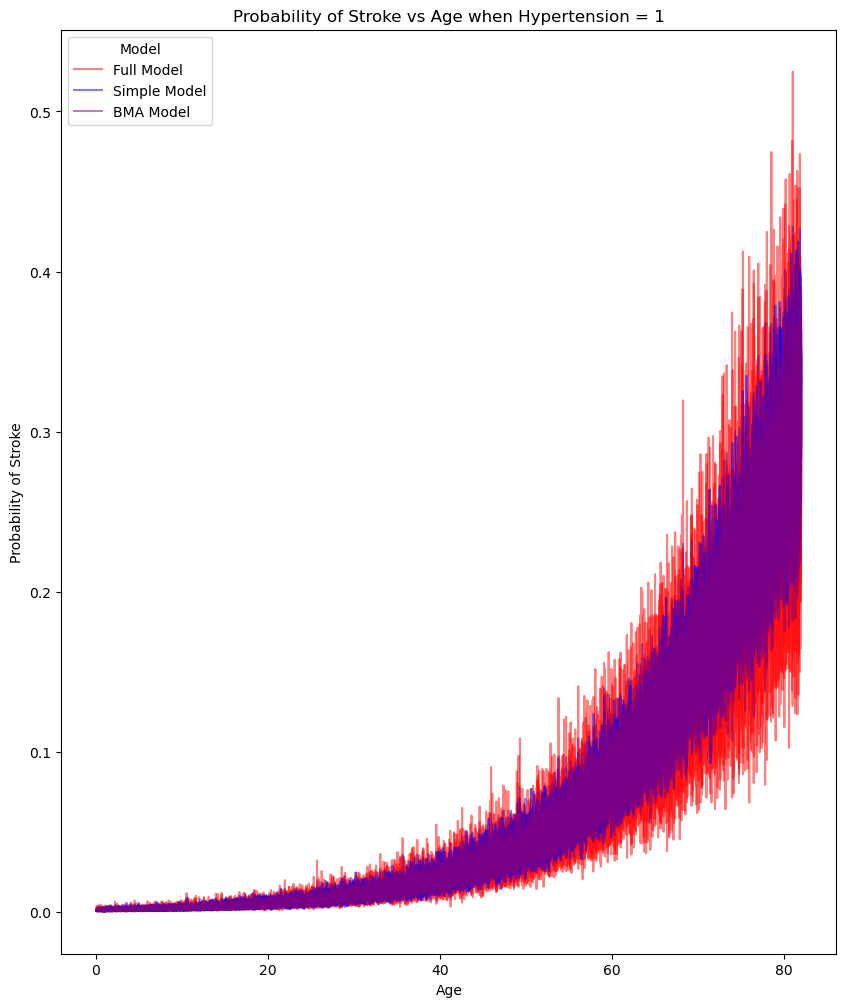

In [53]:
# use WAIC values as weights for BMA
weights = cmp_waic['weight']

# plot of the probability of stroke vs. age for the Bayesian model average
plot_posterior_predictive(weights, full_trace, reduced_trace, 1, 'Probability of Stroke vs Age when Hypertension = 1')

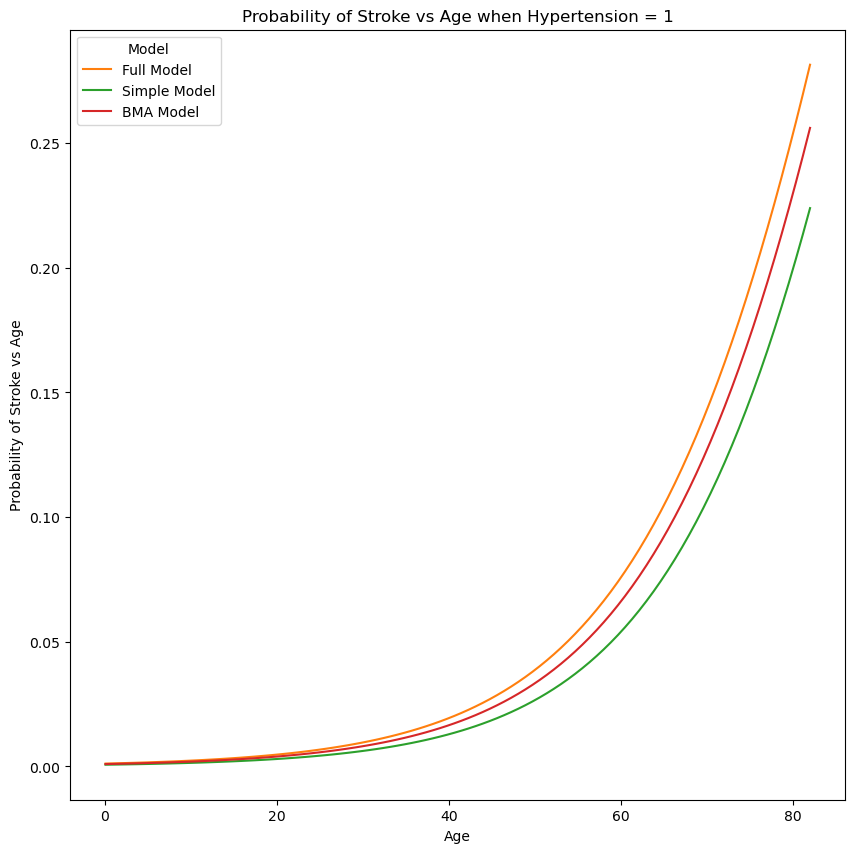

In [54]:
# Computing predictions by combining the models using the WAIC weights
w = cmp_waic.loc['model_full','weight']
weights = [w, 1-w]

# plot of models with bma
plot_posterior_precitive_using_mean(weights, full_trace, reduced_trace, 1, 'Probability of Stroke vs Age when Hypertension = 1')

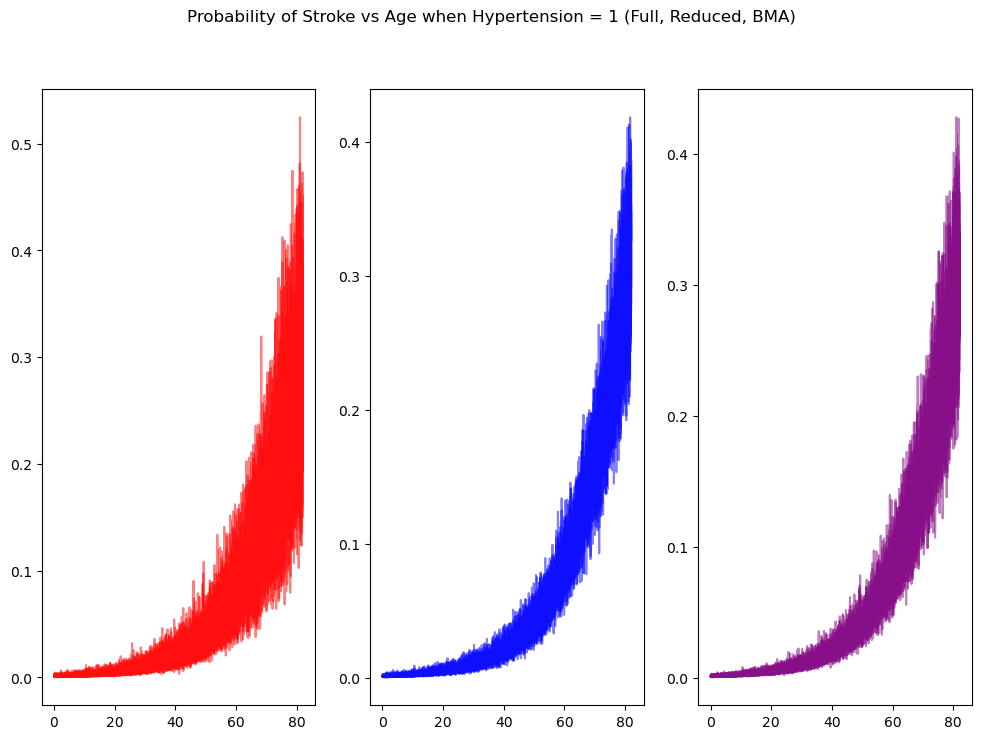

In [55]:
fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = (12, 8))

i = 0
for col in ax:
    if i == 0:
        plot_full_posterior_predictive(
            ax = col,
            hypertension_value = 1
        )
    elif i == 1:
        plot_reduced_posterior_predictive(
            ax = col,
            hypertension_value = 1
        )
    else:
        plot_bma_posterior_predictive(
            ax = col,
            hypertension_value = 1
        )
        
    i += 1

plt.suptitle('Probability of Stroke vs Age when Hypertension = 1 (Full, Reduced, BMA)')
plt.show()

The following plots depict the probability of stroke vs. age, fixing hypertension as 0.

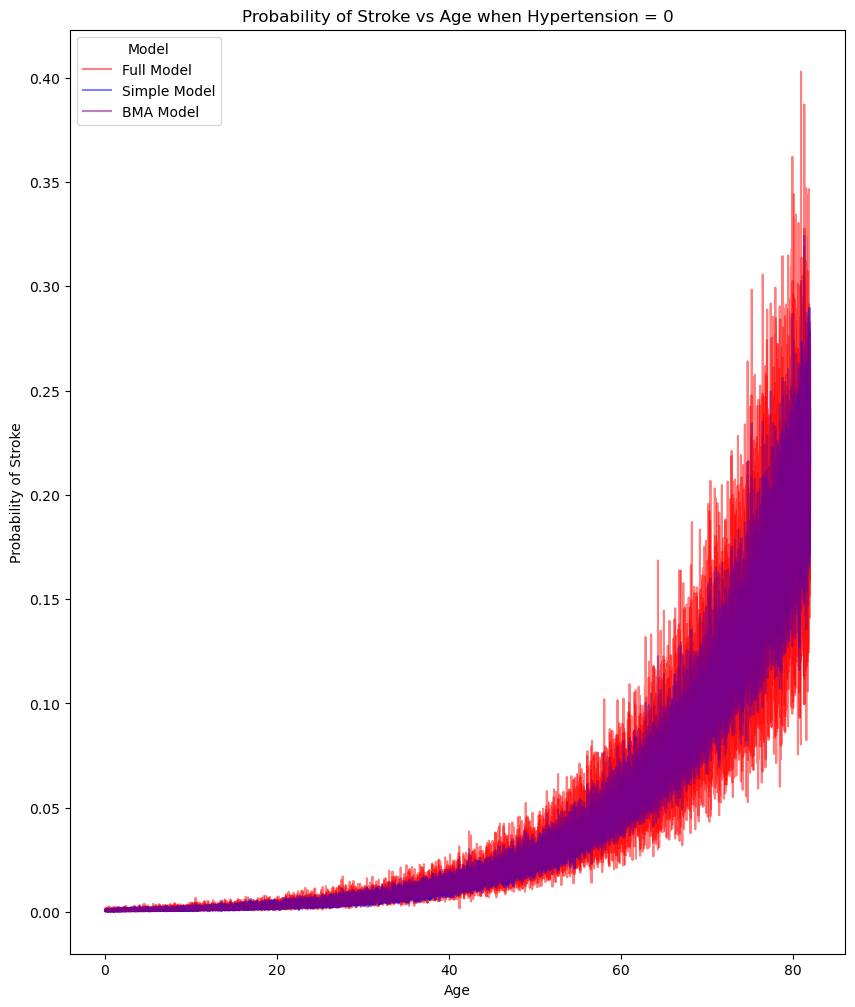

In [56]:
# use WAIC values as weights for BMA
weights = cmp_waic['weight']

# plot of the probability of stroke vs. age for the Bayesian model average

plot_posterior_predictive(weights, full_trace, reduced_trace, 0, 'Probability of Stroke vs Age when Hypertension = 0')

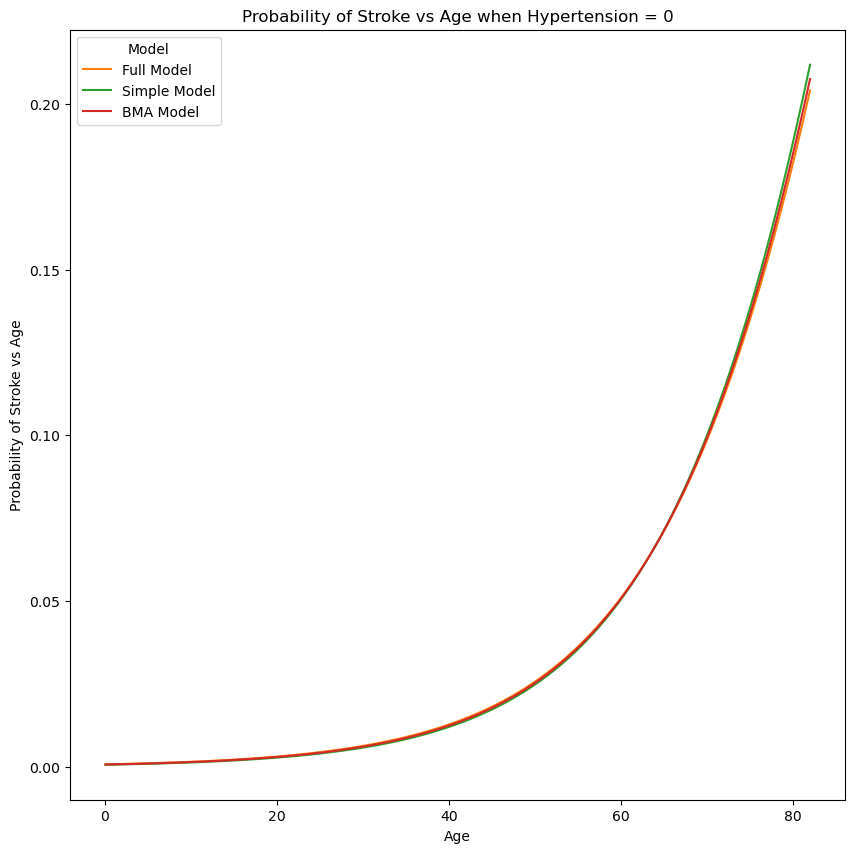

In [57]:
# Computing predictions by combining the models using the WAIC weights
w = cmp_waic.loc['model_full','weight']
weights = [w, 1-w]
# Plot of models with bma
plot_posterior_precitive_using_mean(weights, full_trace, reduced_trace, 0, 'Probability of Stroke vs Age when Hypertension = 0')

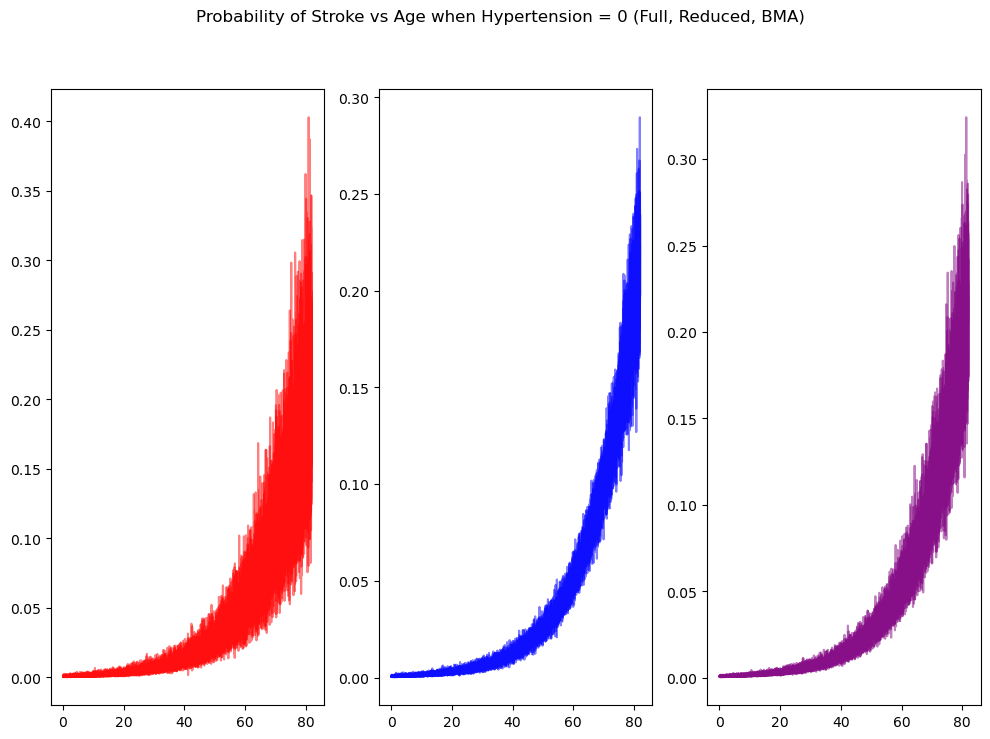

In [58]:
fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = (12, 8))

i = 0
for col in ax:
    if i == 0:
        plot_full_posterior_predictive(
            ax = col,
            hypertension_value = 0
        )
    elif i == 1:
        plot_reduced_posterior_predictive(
            ax = col,
            hypertension_value = 0
        )
    else:
        plot_bma_posterior_predictive(
            ax = col,
            hypertension_value = 0
        )
        
    i += 1

plt.suptitle('Probability of Stroke vs Age when Hypertension = 0 (Full, Reduced, BMA)')
plt.show()

In [59]:
a = reduced_trace.posterior['α'].mean(axis=1).mean(axis=0).to_numpy()
b = reduced_trace.posterior['β'].mean(axis=1).mean(axis=0).to_numpy()

X_test_reduced = X_test[["age", "hypertension"]]

m = a + X_test_reduced.dot(b)
p_reduced = inv_logit(m)

a = full_trace.posterior['α'].mean(axis=1).mean(axis=0).to_numpy()
b = full_trace.posterior['β'].mean(axis=1).mean(axis=0).to_numpy()

m = a + X_test.dot(b)
p_full = inv_logit(m)

p_bma = w*p_full + (1-w)*p_reduced

t_star_bma = calculate_tstar(p_bma, y_hat, y_test)
print('Optimal Threshold:', t_star_bma)
sum((p>=t_star_bma).astype(int) == y_test)/len(y_test)

Optimal Threshold: 0.04


0.6863543788187373

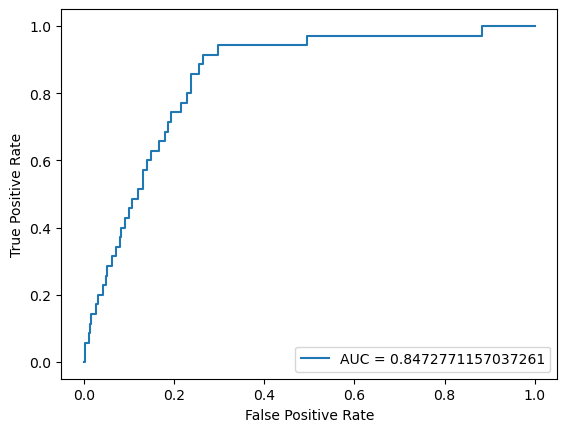

In [60]:
# ROC Curve

fpr, tpr, _ = metrics.roc_curve(y_test,  p_bma)
auc = metrics.roc_auc_score(y_test, p_bma)

plt.plot(fpr, tpr, label = "AUC = "+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

In [61]:
# Confusion Matrix

cm = metrics.confusion_matrix(y_test, (p_bma>=t_star_bma).astype(int))
print(cm)

get_rates(cm)

[[655 292]
 [  2  33]]


{'Precision': 0.102, 'Accuracy': 0.701, 'Recall': 0.943}

## Final Result

- Full Sampling: {'Precision': 0.997, 'Accuracy': 0.713, 'Recall': 0.704}
- Full ADVI: {'Precision': 0.997, 'Accuracy': 0.686, 'Recall': 0.677}
- Reduced Sampling: {'Precision': 0.997, 'Accuracy': 0.686, 'Recall': 0.677}
- BMA: {'Precision': 0.997, 'Accuracy': 0.701, 'Recall': 0.692}

In [62]:
model_results = [
    {
        'model': 'Full Sampling',
        'precision': 0.997,
        'accuracy': 0.713,
        'recall': 0.704
    },
    {
        'model': 'Full ADVI',
        'precision': 0.997,
        'accuracy': 0.686,
        'recall': 0.677
    },
    {
        'model': 'Reduced Sampling',
        'precision': 0.997,
        'accuracy': 0.686,
        'recall': 0.677
    },
    {
        'model': 'BMA',
        'precision': 0.997,
        'accuracy': 0.701,
        'recall': 0.692
    }
]
result_df = pd.DataFrame(model_results)
result_df

,model,precision,accuracy,recall
0,Full Sampling,0.997,0.713,0.704
1,Full ADVI,0.997,0.686,0.677
2,Reduced Sampling,0.997,0.686,0.677
3,BMA,0.997,0.701,0.692
